In [17]:
# type this command in gitbash/terminal: conda install -c conda-forge fbprophet
import pandas as pd
from fbprophet import Prophet
import datetime

In [18]:
df = pd.read_csv('raw_files/sale_prices_state.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.tail()

,Date,CA,TX,NY,FL,IL,PA,OH,MI,GA,...,NH,RI,MT,DE,SD,AK,ND,VT,DC,WY
286,2019-11-30,563523,209358,325925,248103,203907,195918,150953,173597,203623,...,291907,303184,283654.0,257899,206301,307886,236431.0,258948,633135,252517.0
287,2019-12-31,566433,209723,326646,248825,204058,196555,151551,174330,204290,...,293356,304444,284987.0,257775,207033,306078,236708.0,259558,634526,253571.0
288,2020-01-31,569813,210164,327360,249766,204302,197133,152229,175146,205044,...,294946,305755,286402.0,257647,207831,305820,236802.0,260280,637048,254531.0
289,2020-02-29,573975,210591,328101,250981,204527,197735,152916,175948,205955,...,296965,307296,287633.0,257723,208782,303294,237099.0,260677,639504,255456.0
290,2020-03-31,578267,211199,328677,252309,204839,198377,153593,176977,206804,...,299333,308658,288867.0,257521,209684,300073,237454.0,261265,640783,256089.0


In [19]:
# Must rename the Date column to ds and one state to y in order for fbprophet to work 
state = "WY"
df = df[["Date",state]]
df = df.rename(columns = {"Date": "ds", state: "y"})

In [20]:
model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
## Trying to predict housing sales prices 3 years (730 days) into the future. Our dataset stops at 3/31/20. Now our model will predict up to 3/31/2021. 
future = model.make_future_dataframe(periods=1095)
future.tail()

,ds
1381,2023-03-27
1382,2023-03-28
1383,2023-03-29
1384,2023-03-30
1385,2023-03-31


In [22]:
forecast = model.predict(future)
forecast.to_csv(f'DataSets/{state}_Prediction.csv')
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1381,2023-03-27,266660.922640,257409.339022,275336.066186
1382,2023-03-28,267091.085742,257768.607976,275691.571855
1383,2023-03-29,267695.118314,258044.688910,276887.289787
1384,2023-03-30,268460.578266,258919.927970,277036.992049
1385,2023-03-31,269370.606286,260168.333440,278343.132211


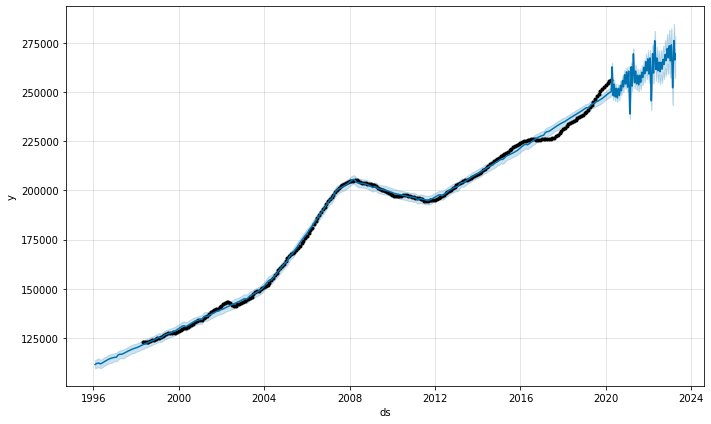

In [23]:
fig1 = model.plot(forecast)

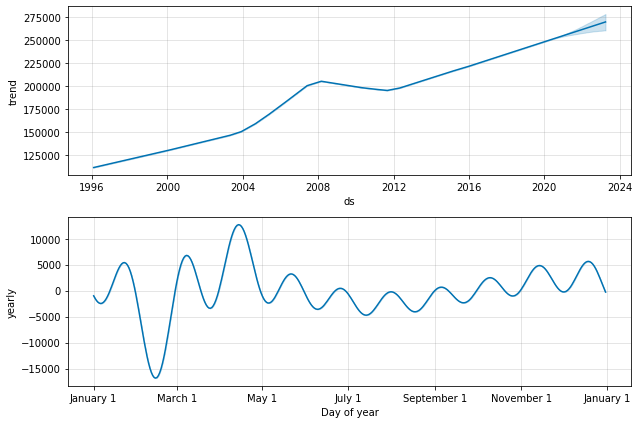

In [24]:
fig2 = model.plot_components(forecast)

In [9]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='8370 days', period='180 days', horizon = '365 days')
df_cv.to_csv(f'DataSets/{state}_Cross_Validation.csv')
df_cv
# Performing a cross validation: the training set is from 1/31/1996 - 4/1/2019 
# The goal is to forecast over a 365 days horizon: it would be from 4/30/2019 to 3/31/2020 

INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-04-01 00:00:00 and 2019-04-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-04-30,187965.301151,186421.918377,189523.229467,191190,2019-04-01
1,2019-05-31,188549.103913,187154.226948,190032.402565,191696,2019-04-01
2,2019-06-30,189091.831124,187571.584979,190577.985050,192437,2019-04-01
3,2019-07-31,189645.163067,188235.137688,191231.482766,193202,2019-04-01
4,2019-08-31,190139.373037,188650.420970,191703.100130,193945,2019-04-01
5,2019-09-30,190657.595401,189122.197141,192242.760836,194608,2019-04-01
6,2019-10-31,191145.315020,189476.225509,192888.936770,195286,2019-04-01
7,2019-11-30,191584.114253,189858.225306,193365.795458,195918,2019-04-01
8,2019-12-31,192069.909969,190269.734130,193890.785452,196555,2019-04-01
9,2020-01-31,192651.840010,190929.765131,194494.806933,197133,2019-04-01


In [10]:
# Analyzing prediction performance 
# MSE: Mean squared error 
# RMSE: Root mean squared error 
# MAE: Mean absolute error 
# MAPE: Mean absolute percent error 
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.to_csv(f'DataSets/{state}_Diagnostics.csv')
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,29 days,1.039868e+07,3224.698849,3224.698849,0.016866,0.016866,0.0
1,60 days,9.902955e+06,3146.896087,3146.896087,0.016416,0.016416,0.0
2,90 days,1.119015e+07,3345.168876,3345.168876,0.017383,0.017383,0.0
3,121 days,1.265109e+07,3556.836933,3556.836933,0.018410,0.018410,0.0
4,152 days,1.448280e+07,3805.626963,3805.626963,0.019622,0.019622,0.0
5,182 days,1.560570e+07,3950.404599,3950.404599,0.020299,0.020299,0.0
6,213 days,1.714527e+07,4140.684980,4140.684980,0.021203,0.021203,0.0
7,243 days,1.878257e+07,4333.885747,4333.885747,0.022121,0.022121,0.0
8,274 days,2.011603e+07,4485.090031,4485.090031,0.022818,0.022818,0.0
9,305 days,2.008079e+07,4481.159990,4481.159990,0.022732,0.022732,0.0


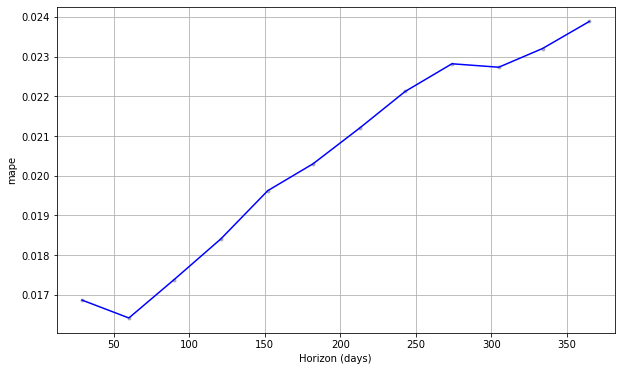

In [11]:
from fbprophet.plot import plot_cross_validation_metric
fig_mape = plot_cross_validation_metric(df_cv, metric='mape')

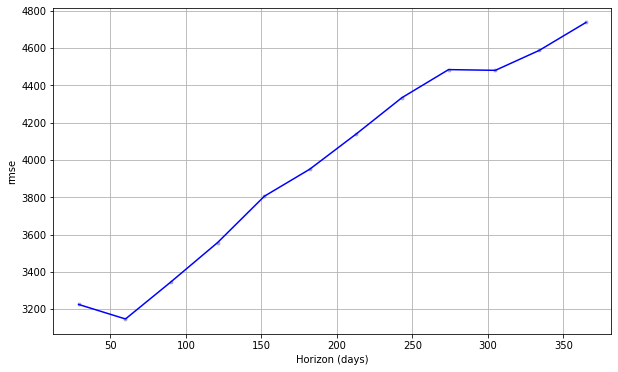

In [12]:
from fbprophet.plot import plot_cross_validation_metric
fig_rmse = plot_cross_validation_metric(df_cv, metric='rmse')

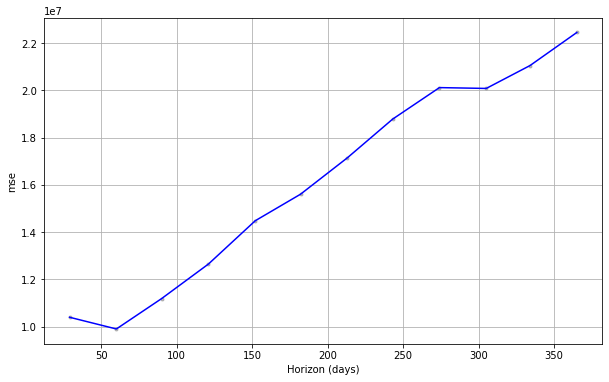

In [13]:
from fbprophet.plot import plot_cross_validation_metric
fig_mse = plot_cross_validation_metric(df_cv, metric='mse')

In [14]:
#Top Populated States
# California (Population: 39,747,267)
# Texas (Population: 29,087,070)
# Florida (Population: 21,646,155)
# New York (Population: 19,491,339)
# Pennsylvania (Population: 12,813,969)
#https://worldpopulationreview.com/states

In [15]:
#Bottom Populated States
# Wyoming (Population: 572,381)
# Vermont (Population: 627,180)
# District of Columbia (Population: 711,571)
# Alaska (Population: 735,720)
# North Dakota (Population: 760,900)